# Notebook for Airconics examples 

This IPython notebook contains examples for generating and rendering the AirCONICS parametric transonic airliner example using the interactive `WebServer` from [PythonOCC-contrib](https://github.com/tpaviot/pythonocc-contrib). Parts are generated under their respective headings and rendered collectively in the final cells.

For examples using the pythonocc-core Qt viewer, refer to the airconics [examples/core directory](https://github.com/p-chambers/occ_airconics/tree/master/examples/core)

In [1]:
from airconics import liftingsurface, engine, fuselage_oml
import airconics.AirCONICStools as act
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer
from IPython.display import display

## Parameter Definitions
Parameters used here correspond to a geometry similar to that of the Boeing 787-8

In [2]:
Propulsion=1
EngineDia=2.9
FuselageScaling=[55.902, 55.902, 55.902]
WingScaleFactor=44.56
WingChordFactor=1.0
Topology=1
EngineSpanStation=0.31
EngineCtrBelowLE=0.3558
EngineCtrFwdOfLE=0.9837
Scarf_deg=3

# Derived Parameters
FuselageHeight = FuselageScaling[2]*0.105
FuselageLength = FuselageScaling[0]
FuselageWidth  = FuselageScaling[1]*0.106
WingApex = [0.1748*FuselageLength,0,-0.0523*FuselageHeight]
# Fin:
FinChordFact = 1.01
FinScaleFact = WingScaleFactor/2.032
# TailPlane
TPChordFact = 1.01
TPScaleFact = WingScaleFactor * 0.388
# Engine:
NacelleLength = 1.95*EngineDia



## Wing, Transonic Airliner

Formulation of lifting surfaces in `occ_airconics` (and AirCONICS) follows the suggestions in Sobester [1] in which geometry--attached curvilinear functionals are used instead of parameters for shape definition. That is, $G(\textbf{f}, \textbf{X})$, where

$$\qquad \textbf{f} = \left[ f_1(\textbf{X}_1), f_2(\textbf{X}_2), ... f_m(\textbf{X}_m)\right],$$
and

$$\textbf{X}_i = \left[x_1^i, x_2^i,...\right], \forall i = 1,...m$$

as opposed to the conventional $G(\bf{X})$ formulation where the shape $G$ changes in response to changes in design parameters $\textbf{X}$. The functions $f_i$ are defined by:

> $Sweep (\epsilon)$

> $Chord (\epsilon)$

> $Rotation (\epsilon)$

> $Twist (\epsilon)$

> $Airfoil (\epsilon)$

where $\epsilon$ represents the spanwise coordinate ranging from 0 at the root of the wing to 1 at the tip. Output of the airfoil function uses the `airconics.primitives.Airfoil` class here, which fits a NURBS curve to airfoil coordinates.

The following code demonstrates construction of a wing using built in examples for a transonic airliner wing and tailplane (below).

In [3]:
# Import all example functional definitions for the Common Research Model (CRM) Wing:
from airconics.examples.wing_example_transonic_airliner import *

# Position of the apex of the wing
P = WingApex

# Class definition
NSeg = 11
ChordFactor = 1
ScaleFactor = 50

# Generate (surface building is done during construction of the class)
Wing = liftingsurface.LiftingSurface(P, mySweepAngleFunctionAirliner, 
                                        myDihedralFunctionAirliner, 
                                        myTwistFunctionAirliner, 
                                        myChordFunctionAirliner, 
                                        myAirfoilFunctionAirliner,
                                        SegmentNo=NSeg,
                                        ScaleFactor=WingScaleFactor,
                                        ChordFactor=WingChordFactor)

# Evaluate the root chord:
RootChord = Wing.RootChord

# Display
renderer = TornadoWebRenderer()
Wing.Display(renderer)
display(renderer)

<TornadoWebRenderer at http://18.0.168.192.in-addr.arpa:58643/get/034e56ae4b114b389569847b2c427531>

## Tailplane, Transonic Airliner

The same `Lifting Surface` class is used here to generate the fin and tailplane of the aircraft, using a different set of input functionals (also defined in `airconics.examples`).

In [4]:
from OCC.gp import gp_Ax1, gp_Pnt, gp_Dir
from airconics.examples.tailplane_example_transonic_airliner import *

# Position of the apex of the fin
P = [36.98-0.49-0.02, 0.0, 2.395-0.141]

SegmentNo = 10

Fin = liftingsurface.LiftingSurface(P, mySweepAngleFunctionFin,
                                    myDihedralFunctionFin,
                                    myTwistFunctionFin,
                                    myChordFunctionFin,
                                    myAirfoilFunctionFin,
                                    SegmentNo=SegmentNo,
                                    ChordFactor=FinChordFact,
                                    ScaleFactor=FinScaleFact)

#    Create the rotation axis centered at the apex point in the x direction
RotAxis = gp_Ax1(gp_Pnt(*P), gp_Dir(1, 0, 0))


Fin.RotateComponents(RotAxis, 90)

# Position of the apex of the tailplane
P = [43, 0.000, 1.633+0.02]

SegmentNo = 100
ChordFactor = 1.01
ScaleFactor = 17.3

TP = liftingsurface.LiftingSurface(P, mySweepAngleFunctionTP,
                                   myDihedralFunctionTP,
                                   myTwistFunctionTP,
                                   myChordFunctionTP,
                                   myAirfoilFunctionTP,
                                   SegmentNo=SegmentNo,
                                   ChordFactor=TPChordFact,
                                   ScaleFactor=TPScaleFact)

# Display
renderer = TornadoWebRenderer()
Fin.Display(renderer)
TP.Display(renderer)
display(renderer)

<TornadoWebRenderer at http://18.0.168.192.in-addr.arpa:58646/get/8cfd59bb048441a48edc02b72a6b6f09>

## Fuselage Transonic Airliner

Fuselage shapes are created following the parameterisation used in Sobester [2]. That is, the outer mould line (OML) is split into a `Nose`, `Central` and `Tail` section, the length of which is described on input to `Fuselage` class as a percentage of the total length. Rib curves are then formed by fitting a NURBS curve to the intersection points of sectional planar cuts and the guide curves of the extremeties of the OML e.g. Port, top and bottom curves. The OML is fitted in `occ_airconics` using the Open CASCADE `ThruSections` loft.

In [5]:
NoseLengthRatio=0.182
TailLengthRatio=0.293

Fus = fuselage_oml.Fuselage(NoseLengthRatio, TailLengthRatio, Scaling=FuselageScaling,
                            NoseCoordinates=[0., 0., 0],
                            CylindricalMidSection=False,
                            Maxi_attempt=5)

# Display
renderer = TornadoWebRenderer()
Fus.Display(renderer)
display(renderer)

('Surface fit attempt ', 1)
('Attempting thrusections surface fit with network density                setup ', array([35, 30, 15,  5, 20]))
Network surface fit succesful on attempt 1


<TornadoWebRenderer at http://18.0.168.192.in-addr.arpa:58649/get/135f847e927b4caf92c5de54495441eb>

In [6]:
# Export (can be commented out)
# act.export_STEPFile([Fus['OML']], 'fuselage.stp')

## Wing-Body Fairing:
The wing-body fairing is here created as a simple ellipsoid shape around the root section of the wing. 

*Note that this component will be displayed only in the final model.*

In [7]:
# WingBodyFairing - A simple ellipsoid:
from airconics.base import AirconicsShape

WTBFZ = RootChord*0.009 #787: 0.2
WTBFheight = 1.8*0.1212*RootChord #787:2.7
WTBFwidth = 1.08*FuselageWidth
WTBFXCentre = WingApex[0] + RootChord/2.0 + RootChord*0.1297 # 787: 23.8
WTBFlength = 1.167*RootChord #787:26

WBF_shape = act.make_ellipsoid([WTBFXCentre, 0, WTBFZ], WTBFlength, WTBFwidth, WTBFheight)
WBF = AirconicsShape(components={'WBF': WBF_shape})

## Engine + Pylon

First, obtain the wing section and chord at which the engine will be fitted, then fit then engine. The default inputs to the Engine class produce a turbofan engine with Nacelle similar to that of the RR Trent 1000 / GEnx and its pylon (**Currently a flat plate only**).

In [8]:
EngineSection, Chord = act.CutSect(Wing['Surface'], EngineSpanStation)
CEP = Chord.EndPoint()
Centreloc = [CEP.X()-EngineCtrFwdOfLE*NacelleLength,
            CEP.Y(), 
            CEP.Z()-EngineCtrBelowLE*NacelleLength]

eng =  engine.Engine(Chord,
                     CentreLocation=Centreloc,
                     ScarfAngle=Scarf_deg,
                     HighlightRadius=EngineDia/2.0,
                     MeanNacelleLength=NacelleLength)

# Display
renderer = TornadoWebRenderer()
eng.Display(renderer)
display(renderer)


<TornadoWebRenderer at http://18.0.168.192.in-addr.arpa:58652/get/02b3b587d754414592815ea83bb0f443>

## Miscelaneous operations

In [9]:
# Trim the inboard section of the main wing:
CutCirc = act.make_circle3pt([0,WTBFwidth/4.,-45], [0,WTBFwidth/4.,45], [90,WTBFwidth/4.,0])
CutCircDisk = act.PlanarSurf(CutCirc)
Wing['Surface'] = act.TrimShapebyPlane(Wing['Surface'], CutCircDisk)

#Mirror the main wing and tailplane using class methods:
Wing2 = Wing.MirrorComponents(plane='xz')
TP2 = TP.MirrorComponents(plane='xz')
eng2 = eng.MirrorComponents(plane='xz')

can work? True
error status: - Ok
Note: MirrorComponents currently mirrors only the shape
components, other attributes will not be mirrored

Note: MirrorComponents currently mirrors only the shape
components, other attributes will not be mirrored

Note: MirrorComponents currently mirrors only the shape
components, other attributes will not be mirrored



## Ipython Cell Renderer:

In [10]:
renderer = TornadoWebRenderer()
#    display all entities:
# Fuselage and wing-body fairing
Fus.Display(renderer)
WBF.Display(renderer)

# #The Wings:
Wing.Display(renderer)
Wing2.Display(renderer)

#The Tailplane:
TP.Display(renderer)
TP2.Display(renderer)

#The Fin:
Fin.Display(renderer)

#The Engines:
eng.Display(renderer)
eng2.Display(renderer)

# Finally show the renderer
display(renderer)

<TornadoWebRenderer at http://18.0.168.192.in-addr.arpa:58655/get/5c72955c519e402f8af1e3469e4fc35e>

# Development

## Topology model

This is a work in progress towards a topologically flexible model based on the tree-type definition described in Sobester [1]. Note the geometry is not currently defined by the tree however, the tree is simply stored as a result of adding components - this is for demonstration only, and the process is yet to be automated.

The mirror line is also not yet included in this representation, however should exist between central objects (Fuselage, Fin) and the mirror objects (Tail Plane, Wing, Engine).

E(L, L, L(P))


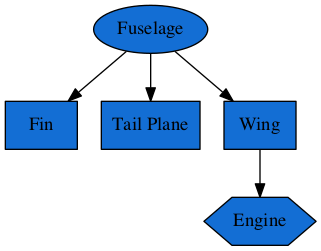

In [11]:
from airconics.topology import Topology
from IPython.display import Image
import pydot

topo = Topology()

# Note: no checks are done on the validity of the tree yet,
#  it is the users responsibility to input correct affinities
topo.AddPart(Fus, 'Fuselage', 3)
topo.AddPart(Fin, 'Fin', 0)
topo.AddPart(TP, 'Tail Plane', 0)
topo.AddPart(Wing, 'Wing', 1)
topo.AddPart(eng, 'Engine', 0)

topo.Display(renderer)

# print the Topology (resembles a LISP tree)
print(topo)

# Create the graph with pydot
graph = pydot.graph_from_dot_data(topo.export_graphviz())
Image(graph.create_png())

### References

[1] Sobester, A., “Four Suggestions for Better Parametric Geometries,”
    10th AIAA Multidisciplinary Design Optimization Conference,
    AIAA SciTech, American Institute of Aeronautics and Astronautics,
    jan 2014.
    
[2] Sobester, A., “Self-Designing Parametric Geometries,” 56th AIAA/ASCE/AH-
    S/ASC Structures, Structural Dynamics, and Materials Conference, AIAA
    SciTech, American Institute of Aeronautics and Astronautics, jan 2015.

In [12]:
# # This cell can be used to start a freecad window, create a new document and transfer the airconics
# # Wing shape to the viewer
# # NOTE:requires the same version of Open CASCADE though and is buggy, users should avoid this for now

# import sys
# sys.path.append('/usr/lib/freecad/lib')
# import FreeCAD
# import FreeCADGui
# %gui qt
# FreeCADGui.showMainWindow()

# doc = FreeCAD.newDocument()

# import Part

# import airconics 
# # Import all example functional definitions for the Common Research Model (CRM) Wing:
# from airconics.examples.wing_example_transonic_airliner import *

# # Position of the apex of the wing
# P = [0., 0., 0.]

# # Class definition
# NSeg = 10
# ChordFactor = 1
# ScaleFactor = 50

# Wing = liftingsurface.LiftingSurface(P, mySweepAngleFunctionAirliner, 
#     myDihedralFunctionAirliner, 
#     myTwistFunctionAirliner, 
#     myChordFunctionAirliner, 
#     myAirfoilFunctionAirliner, SegmentNo=NSeg, ScaleFactor=ScaleFactor)
# surf = Wing['Surface']
# w = Part.__fromPythonOCC__(surf)
# doc.recompute()
# Part.show(w)